В данном задании вам нужно будет

проанализировать АБ тест, проведенный на реальных пользователях Яндекса
подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами
определить характер этих изменений и практическую значимость вводимого изменения
понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)

Описание данных:

userID: уникальный идентификатор пользователя

browser: браузер, который использовал userID

slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)

n_clicks: количество кликов, которые пользоваль совершил за n_queries

n_queries: количество запросов, который совершил userID, пользуясь браузером browser

n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика


Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv('ab_browser_test.csv')

In [3]:
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [4]:
data.shape

(566134, 6)

In [8]:
data.browser.describe()

count         566134
unique             6
top       Browser #4
freq          156833
Name: browser, dtype: object

In [7]:
data.tail()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
566129,603133,Browser #14,control,1,2,1
566130,603134,Browser #2,exp,4,2,0
566131,603135,Browser #4,control,0,1,1
566132,603136,Browser #4,control,2,3,1
566133,603137,Browser #2,exp,3,1,0


In [16]:
data.browser=[int(data.browser[i][9:]) for i in range(data.shape[0])]

In [17]:
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,2,exp,23,32,19
1,3,4,exp,3,4,2
2,5,4,exp,29,35,16
3,6,4,control,12,6,0
4,7,4,exp,54,68,30


**Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.**

Задание 1. Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

In [21]:
data[data.slot=='exp'].n_clicks.sum()

3261823

In [23]:
data[data.slot=='control'].n_clicks.sum()

3210027

In [25]:
3261823/3210027*100-100


1.6135689824415778

Задание 2. 

Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения.

In [104]:
exp = data[data.slot=='exp'].n_clicks
contr = data[data.slot=='control'].n_clicks

In [26]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data))) 
    # генерим 1000 выборок размера исходных данных из индексов от 0 до лен дата
    samples = data[indices] 
    # получаем эти индексы, дальше получаем выборки, применяя эти индексы набору данных и возвращаем выборки.
    return samples

In [27]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)]) 
    # 95% интевар. слева 2,5 и справа 97,5 квантили
    return boundaries
# Функция очень простая, передаём ей статистики, передаём ей α, а дальше берём наши статистики и упорядочиваем их
# по возрастанию, и говорим, что мы просто отрезаем слева и справа по кусочку равному α / 2 (слева) и (1 − α) / 2 (справа). 
#Давайте начнём с того, что получим независимые интервальные оценки медианы для клиентов двух типов. 

In [32]:
np.random.seed(0)

exp_median_scores = list(map(np.median, get_bootstrap_samples(np.array(exp), 1000)))
contr_median_scores = list(map(np.median, get_bootstrap_samples(np.array(contr), 1000)))

print("95% confidence interval for the exp median:",  stat_intervals(exp_median_scores, 0.05))
print("95% confidence interval for the contr median :",  stat_intervals(contr_median_scores, 0.05))

95% confidence interval for the exp median: [5. 5.]
95% confidence interval for the contr median : [4. 4.]


**интервалы не пересакаются. медианное число кликов в контрольной группе меньше**

In [34]:
exp_mean_scores = list(map(np.mean, get_bootstrap_samples(np.array(exp), 1000)))
contr_mean_scores = list(map(np.mean, get_bootstrap_samples(np.array(contr), 1000)))

print("95% confidence interval for the exp mean:",  stat_intervals(exp_mean_scores, 0.05))
print("95% confidence interval for the contr mean :",  stat_intervals(contr_mean_scores, 0.05))

95% confidence interval for the exp mean: [11.50841688 11.65653189]
95% confidence interval for the contr mean : [11.20447305 11.35305223]


**интервалы не пересакаются. среднее число кликов в контрольной группе меньше**

In [39]:
stat_intervals(list(map(lambda x: x[0] - x[1], zip(exp_mean_scores, contr_mean_scores))),0.05)

array([0.19642869, 0.41012844])

In [40]:
stat_intervals(list(map(lambda x: x[0] - x[1], zip(exp_median_scores, contr_median_scores))),0.05)

array([1., 1.])

**Кликов больше в эксп. группе**

Задание 3 

Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

Посмотрите на выданные вам данные и выберите все верные варианты ответа относительно проверки гипотезы о равенстве среднего количества кликов в группах.

Зажание 4


t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных.

Для простоты рассмотрим одновыборочный t-критерий. Чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

среднее значение в выборке было распределено нормально N(μ,σ2n)

несмещенная оценка дисперсии c масштабирующим коэффициентом была распределена по хи-квадрат c n−1 степенями свободы χ2(n−1)

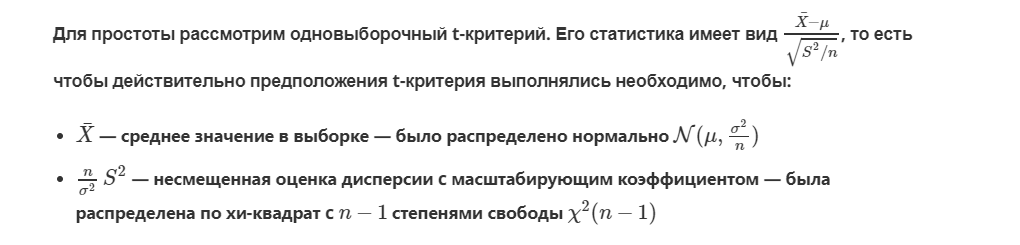

In [41]:
from IPython.display import Image
Image("Стьюдент.PNG")

Простое доказательство необходимости и достаточности этого требования можно посмотреть в самом последнем абзаце этого вопроса. Усвоение этого доказательства не обязательно для выполнения задания.

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными в рамках данного вопроса.

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого

    1.Получите из данных n_boot_samples псевдовыборок.
    2.По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared)
    3.Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения
    4.Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте qq-plot с помощью scipy.stats.probplot для хи-квадрат распределения с помощью команды scipy.stats.probplot(control_boot_chi_squared, dist="chi2", 
                     sparams=(n-1), plot=plt)
    Где sparams=(n-1) означают число степеней свободы = длине выборки - 1.

Чтобы получить такой же ответ, как у нас, зафиксируйте seed и количество псевдовыборок:

np.random.seed(0)
n_boot_samples = 500

Где sparams=(n-1) означают число степеней свободы = длине выборки - 1.

Чтобы получить такой же ответ, как у нас, зафиксируйте seed и количество псевдовыборок:

In [91]:
contr_mean_scores1 = list(map(np.mean, get_bootstrap_samples(np.array(contr), 500)))

In [92]:
samples = get_bootstrap_samples(np.array(contr), 500) 

In [93]:
mean=samples.mean(axis=1) # средние в каждой из 500 псевдовыборок

In [94]:
mean.shape

(500,)

In [95]:
samples.shape

(500, 284554)

In [96]:
delta = samples - mean[:, np.newaxis] 
# увеличил массив на одно измерение с пом-ью newaxis и найдем разницу для каждомго элмена массива
control_boot_chi_squared = np.sum(delta*delta, axis=1)


In [97]:
control_boot_chi_squared.shape # сумма квадратов отклнения 

(500,)

In [88]:
from scipy import stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


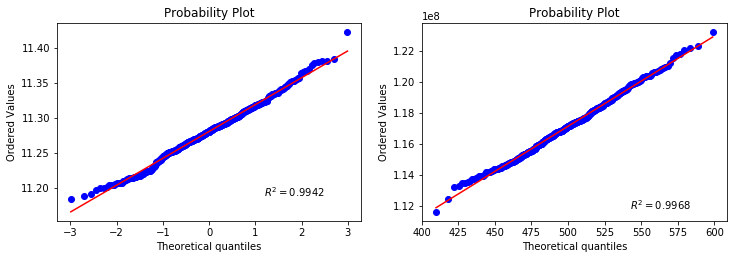

In [100]:
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(contr_mean_scores1, dist="norm", plot=pylab,  rvalue=True)
pylab.subplot(2,2,2)
stats.probplot(control_boot_chi_squared, dist="chi2", 
                 sparams=(control_boot_chi_squared.shape[0]-1), plot=plt,  rvalue=True)
pylab.show()

**среднее значение и выборочная дисперсия распределены нормально. Критерий Стьюдента применять можем**

В качестве ответа отметьте верные утвердения о значениях R^2 
 , которые генерирует scipy.stats.probplot при отображении qq-графиков: одно c графика для среднего и одно с графика для выборочной суммы квадратов отклонения от выборочной суммы.



Задание 5. 

Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? Выберите все правильные ответы

**'userID' И 'browser' - уникальный пользователь**

In [158]:
exp_data = data[data.slot=='exp']

In [159]:
contr_data = data[data.slot=='control']

In [160]:
exp_data.shape

(281580, 6)

In [161]:
exp_data.groupby(['userID', 'browser']).agg(sum).n_clicks.shape

(281580,)

In [162]:
contr_data.shape

(284554, 6)

In [163]:
contr_data.groupby(['userID', 'browser']).agg(sum).n_clicks.shape

(284554,)

In [164]:
exp_clicks=exp_data.groupby(['userID', 'browser']).agg(sum).n_clicks
contr_clicks=contr_data.groupby(['userID', 'browser']).agg(sum).n_clicks

In [166]:
stats.mannwhitneyu(exp_clicks, contr_clicks)[1]

3.1236179006848145e-75

Гипотиза о равенстве средних отвергается 

Задание 6

Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с alpha=0.05

In [141]:
browswer=data.browser.unique()

In [145]:
list(enumerate(browswer))

[(0, 2), (1, 4), (2, 14), (3, 17), (4, 20), (5, 22)]

In [154]:
p_data = []

for  l_column in browswer:
    exp_clicks=exp_data[exp_data.browser==l_column].groupby(['userID', 'browser']).agg(sum).n_clicks 
    contr_clicks=contr_data[contr_data.browser==l_column].groupby(['userID', 'browser']).agg(sum).n_clicks
    p=stats.mannwhitneyu(exp_clicks, contr_clicks)[1]
    p_data.append(p)
    

In [155]:
p_data

[0.0272438604197241,
 0.40760617658454984,
 0.0,
 0.03740060143010802,
 0.45366656388735377,
 0.2574055152210032]

Сделаем мноожественную поправку

In [167]:
from statsmodels.sandbox.stats.multicomp import multipletests 

In [168]:
reject, p_corrected, a1, a2 = multipletests(p_data, 
                                            alpha = 0.05, 
                                            method = 'holm') 

In [169]:
reject, p_corrected

(array([False, False,  True, False, False, False]),
 array([0.1362193 , 0.81521235, 0.        , 0.14960241, 0.81521235,
        0.77221655]))

**Для пяти браузеров отличия не значими!**

Задание 7.

Для каждого браузера в каждой из двух групп (control и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

In [181]:
perc_data = []

for  l_column in browswer:
    exp_nonclicks=sum(exp_data[exp_data.browser==l_column].n_nonclk_queries)
    exp_n_queries=sum(exp_data[exp_data.browser==l_column].n_queries)
    contr_nonclicks=sum(contr_data[contr_data.browser==l_column].n_nonclk_queries)
    contr_n_queries=sum(contr_data[contr_data.browser==l_column].n_queries)
    perc=exp_nonclicks/exp_n_queries*100
    perc1= contr_nonclicks/contr_n_queries*100
    
    perc_data.append((perc,perc1))

In [182]:
perc_data

[(44.982746948554706, 45.96274717919465),
 (45.14294190358467, 46.97092963514274),
 (43.755617361273295, 57.59041136008114),
 (36.93741284866483, 36.29936674628208),
 (38.97737648371716, 40.540484743383296),
 (39.85394721969546, 40.593976593513354)]

In [ ]:
for i,j in enumerate(browswer(:
    exp_data = data['browser'== i & 'slot' == exp].n_clicks